# Análisis Espacial para Selección de Municipio y Área Óptima (Nivel 1 y 2)
**Curso:** Programación SIG. Universidad Nacional de Colombia. Facultad de Ciencias Agrarias.  
**Autor:** Daniela Rayo Álvarez  
**Fecha:** 2025-06-17  

## Objectives  
* Introduce core **vector‑based spatial operations** available in Python.  
* Apply these operations to Colombian municipal, agro‑environmental and climate datasets.  
* Develop students’ ability to adapt and extend example code.  
* Provide hands‑on practice through **“Now it’s your turn”** exercises.  


## Prerequisites  
This notebook willl use the following datasets

| File | Description | CRS / key fields |
|------|-------------|------------------|
| `Catalogo_Estaciones_IDEAM.csv` | IDEAM meteorological‑station catalogue (lon, lat, alt) | WGS 84 |
| `Evaluaciones_Agropecuarias_Municipales_EVA.csv` | Municipal agricultural production statistics | `COD_MPIO`, crop, area, production |
| `precipitacion.csv` | Daily precipitation per station | Station ID, date, value |
| `municipios_colombia.shp` | Colombian municipalities | EPSG 3116 (MAGNA‑Sirgas / Colombia Bogotá) |

Activate the environment and launch **Jupyter Lab** before running the cells below.


## 1  Introduction  
Spatial operations allow us to ask *where* questions about our data: Which municipalities intersect a given buffer?  
Which weather station is nearest to each crop‑growing area?  
Geometry operations, by contrast, modify or derive new geometries – simplifying boundaries, buffering points, or rotating shapes.  

We will follow and extend chapters 3 and 4 of **_Geocomputation with Python_** (pygeocompx), applying every concept to real Colombian datasets.


### Data used in this notebook  
We combine four datasets:

1. **Municipal boundaries** – official shapefile from DANE (see *MGN2018 Instructivo*).  
2. **EVA** agricultural statistics – municipal‑level production for major crops.  
3. **IDEAM stations** – catalogue with coordinates and basic metadata.  
4. **Daily precipitation** – station‑day totals.

These provide an agricultural–environmental case study for spatial analysis.


## Configuración inicial y carga de datos

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import Point, box
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx

In [2]:
# Definir rutas
root_folder = "/notebooks/documentos"
SHAPE_MUN = root_folder + '/municipios_colombia.shp'
EVA_CSV   = root_folder + '/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder + '/Catalogo_Estaciones_IDEAM.csv'
VIAS      = root_folder + '/Vias_Colombia.shp'
runap     = root_folder + '/runap.shp'

In [3]:
print(SHAPE_MUN)
print(EVA_CSV)
print(EST_CSV)
print(VIAS)
print(runap)

/notebooks/documentos/municipios_colombia.shp
/notebooks/documentos/Evaluaciones_Agropecuarias_Municipales_EVA.csv
/notebooks/documentos/Catalogo_Estaciones_IDEAM.csv
/notebooks/documentos/Vias_Colombia.shp
/notebooks/documentos/runap.shp


## Paso 1: Preparación de datos y CRS

In [4]:
# Municipios
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# Vías
gdf_vias = gpd.read_file(VIAS).to_crs(epsg=9377)

# RUNAP
gdf_runap = gpd.read_file(runap).to_crs(epsg=9377)

# EVA
eva = pd.read_csv(EVA_CSV).rename(columns={"CÓD. MUN.": "cod_mun"})
eva["cod_mun"] = eva["cod_mun"].astype(str).str.zfill(5)

# Estaciones IDEAM
df_est = pd.read_csv(EST_CSV, encoding="latin1", sep=';')
coords = df_est["Ubicación"].str.strip("()").str.split(",", expand=True).astype(float)
df_est["lat"], df_est["lon"] = coords[0], coords[1]
gdf_est = gpd.GeoDataFrame(df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326").to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows • {len(gdf_vias):,} vias • {len(gdf_runap):,} runap")

# Homogeneizar códigos
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)


1,122 municipalities • 8,973 stations • 206,068 EVA rows • 108,228 vias • 1,785 runap


## Paso 2: Criterios de análisis a nivel municipal

### 2.1 - Número de estaciones IDEAM por municipio

In [5]:
stations_per_mun = gpd.sjoin(gdf_est, gdf_mun[['MPIO_CCDGO', 'geometry']], predicate='within')
est_counts = stations_per_mun.groupby("MPIO_CCDGO").size().reset_index(name='ideam_count')

#print("Resultado de la unión espacial (stations_per_mun):")
#print(stations_per_mun)
#print("Conteo de estaciones por municipio (est_counts):")
#print(est_counts)

### 2.2 - Densidad de vías por municipio

In [12]:
# Intersecar vías con municipios
vias_in_mun = gpd.overlay(gdf_vias, gdf_mun[["MPIO_CCDGO", "geometry"]], how='intersection')
print(f"Vías intersectadas con municipios: {len(vias_in_mun)} segmentos")

# Paso 1: calcular longitud individual de cada línea (en metros)
vias_in_mun['length_m'] = vias_in_mun.geometry.length
print("Longitudes individuales calculadas.")

# Paso 2: sumar longitudes por municipio
vias_length = vias_in_mun.groupby("MPIO_CCDGO")['length_m'].sum().reset_index()
print(f"Longitudes agregadas por municipio: {vias_length.shape[0]} municipios")

Vías intersectadas con municipios: 121525 segmentos
Longitudes individuales calculadas.
Longitudes agregadas por municipio: 577 municipios


### 2.3 - Producción de maíz por municipio

In [9]:
# Filtrar registros de maíz (ignorando mayúsculas/minúsculas)
maiz_eva = eva[eva["CULTIVO"].str.upper() == "MAIZ"]
print(f"Registros de maíz encontrados: {len(maiz_eva)}")

# Agrupar y sumar la producción por municipio
maiz_prod = (
    maiz_eva.groupby("cod_mun")["Producción\n(t)"]
    .sum()
    .reset_index()
    .rename(columns={"cod_mun": "MPIO_CCDGO", "Producción\n(t)": "maiz_prod_ton"})
)
print(f"Producción agregada por municipio: {maiz_prod.shape[0]} municipios")

# Vista previa de resultados
print(maiz_prod.head())

Registros de maíz encontrados: 24965
Producción agregada por municipio: 1063 municipios
  MPIO_CCDGO  maiz_prod_ton
0      05002          12411
1      05004            224
2      05021             45
3      05030            311
4      05031           2035


### 2.4 - Población interpolada por municipio (ejemplo usando área como proxy)

In [10]:
# Calcular área de cada municipio
gdf_mun['area_m2'] = gdf_mun.area
gdf_mun['population'] = gdf_mun['area_m2'] / 1e6  # Proxy: 1 persona por km²
print(f"Áreas y población proxy calculadas para {len(gdf_mun)} municipios.")

# Crear grilla espacial
bounds = gdf_mun.total_bounds
res = 100000  # 100 km
cols = list(range(int(bounds[0]), int(bounds[2]), res))
rows = list(range(int(bounds[1]), int(bounds[3]), res))
polygons = [box(x, y, x+res, y+res) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_mun.crs)
print(f"Grilla generada con {len(grid)} celdas de {res/1000} km de lado.")

# Superposición municipio-grilla
mun_grid = gpd.overlay(
    gdf_mun[['MPIO_CCDGO', 'area_m2', 'population', 'geometry']],
    grid
)
print(f"Intersecciones municipio-grilla generadas: {len(mun_grid)}")

# Cálculos de proporción de área y población por celda
mun_grid['area_sub'] = mun_grid.area
mun_grid['area_prop'] = mun_grid['area_sub'] / mun_grid['area_m2']
mun_grid['population_part'] = mun_grid['population'] * mun_grid['area_prop']
print("Asignación proporcional de población completada.")

# Agrupar población por municipio
pop_by_mun = mun_grid.groupby("MPIO_CCDGO")['population_part'].sum().reset_index()
print(f"Población redistribuida agregada por municipio: {pop_by_mun.shape[0]} municipios")
print(pop_by_mun.head())

Áreas y población proxy calculadas para 1122 municipios.
Grilla generada con 340 celdas de 100.0 km de lado.
Intersecciones municipio-grilla generadas: 2048
Asignación proporcional de población completada.
Población redistribuida agregada por municipio: 581 municipios
  MPIO_CCDGO  population_part
0      00001    107206.338608
1      00002       506.952804
2      00003      1379.898716
3      00004       296.974188
4      00006      3411.725411


## Paso 3: Multi-criterio y ranking final

In [13]:
# Unión de métricas
mun_scores = gdf_mun[['MPIO_CCDGO', 'MPIO_CNMBR', 'area_m2']].copy()
mun_scores = mun_scores.merge(est_counts, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(vias_length, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(maiz_prod, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(pop_by_mun, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.fillna(0)
print(f"Datos combinados: {mun_scores.shape[0]} municipios con métricas unidas.")

# Normalización de variables
scaler = MinMaxScaler()
mun_scores[['C1_estaciones', 'C2_vias_km_km2', 'C3_maiz_prod', 'C4_poblacion']] = scaler.fit_transform(
    pd.DataFrame({
        'C1_estaciones': mun_scores['ideam_count'],
        'C2_vias_km_km2': mun_scores['length_m'] / (mun_scores['area_m2'] + 1e-6),
        'C3_maiz_prod': mun_scores['maiz_prod_ton'] / (mun_scores['area_m2'] + 1e-6),
        'C4_poblacion': mun_scores['population_part']
    }))
print("Normalización completada.")

# Puntaje compuesto
mun_scores['SCORE'] = (
    0.25 * mun_scores['C1_estaciones'] +
    0.25 * mun_scores['C2_vias_km_km2'] +
    0.25 * mun_scores['C3_maiz_prod'] +
    0.25 * mun_scores['C4_poblacion'])
print("Puntaje compuesto calculado.")

# Mostrar los 10 municipios con mayor score
top10 = mun_scores.sort_values('SCORE', ascending=False).head(10)
print("Top 10 municipios con mayor SCORE:")
print(top10[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])


Datos combinados: 1122 municipios con métricas unidas.
Normalización completada.
Puntaje compuesto calculado.
Top 10 municipios con mayor SCORE:
     MPIO_CCDGO    MPIO_CNMBR     SCORE
628       00001    SAN ANDRÉS  0.750000
867       00001  AGUA DE DIOS  0.579481
637       00001         TUNJA  0.556989
256       00001       ARMENIA  0.555998
1061      00001   BUCARAMANGA  0.544613
466       00001  BARRANQUILLA  0.544193
602       00001     SINCELEJO  0.524330
282       00001      MEDELLÍN  0.518171
229       00001     MANIZALES  0.515445
16        00001       POPAYÁN  0.514175


## Nivel 2 — Selección intra-municipal (área óptima)

### 4.1 - Filtrar mejor municipio y crear grilla fina

In [23]:
# Seleccionar el mejor municipio
mejor_municipio = top10.iloc[0]['MPIO_CCDGO']

#Municipio seleccionado
mun_sel = gdf_mun[gdf_mun['MPIO_CCDGO'] == mejor_municipio]
print(f"Municipio con mayor SCORE: {mejor_municipio} - {mun_sel.iloc[0]['MPIO_CNMBR']}")

# Crear grilla de 1 km x 1 km
xmin, ymin, xmax, ymax = mun_sel.total_bounds
res = 1000  # 1 km en metros
cols = list(range(int(xmin), int(xmax), res))
rows = list(range(int(ymin), int(ymax), res))
grid_cells = [box(x, y, x+res, y+res) for x in cols for y in rows]
grid_fina = gpd.GeoDataFrame({'geometry': grid_cells}, crs=mun_sel.crs)
print(f"Grilla de 1 km² creada con {len(grid_fina)} celdas.")

# Intersecar grilla con el municipio seleccionado
grid_fina = gpd.overlay(grid_fina, mun_sel, how='intersection')
print(f"Celdas de la grilla dentro del municipio: {len(grid_fina)}")

Municipio con mayor SCORE: 00001 - FLORENCIA
Grilla de 1 km² creada con 2950644 celdas.
Celdas de la grilla dentro del municipio: 113741


In [62]:
mun_sel = gdf_mun[gdf_mun['MPIO_CDPMP'] == '18001'] #Florencia
print(mun_sel.shape)  # (1, n)

(1, 94)


In [57]:
florencia_buffer = mun_sel.copy()
florencia_buffer["geometry"] = florencia_buffer.geometry.buffer(10000)

estaciones_20km_florencia = gpd.sjoin(
    gdf_est,
    florencia_buffer,
    how='inner',
    predicate='intersects'
)

print(estaciones_20km_florencia.head())
print(f"Número de estaciones dentro de 20 km de Florencia: {len(estaciones_20km_florencia)}")

          Codigo                       Nombre            Categoria  Estado  \
8       44037040  EL ROSARIO - AUT [44037040]         Limnigráfica  Activa   
16      44037060   FLORENCIA-HACHA [44037060]         Limnigráfica  Activa   
316   4403000112       MARACAIBO [4403000112]        Pluviométrica  Activa   
430     44035040   FLORENCIA - AUT [44035040]  Climática Principal  Activa   
2242    21060040           PITA LA [21060040]        Pluviométrica  Activa   

     Departamento            Municipio                   Ubicación  Altitud  \
8         Caquetá  Florencia (Caquetá)     (1.72525, -75.66638889)      600   
16        Caquetá  Florencia (Caquetá)  (1.62116667, -75.61922222)      270   
316       Caquetá  Florencia (Caquetá)  (1.61052778, -75.48616667)      277   
430       Caquetá  Florencia (Caquetá)       (1.733, -75.64502778)      600   
2242        Huila               Garzón  (2.20202778, -75.54858333)     1330   

     Fecha_instalacion Fecha_suspension  ... STP51_SECU 

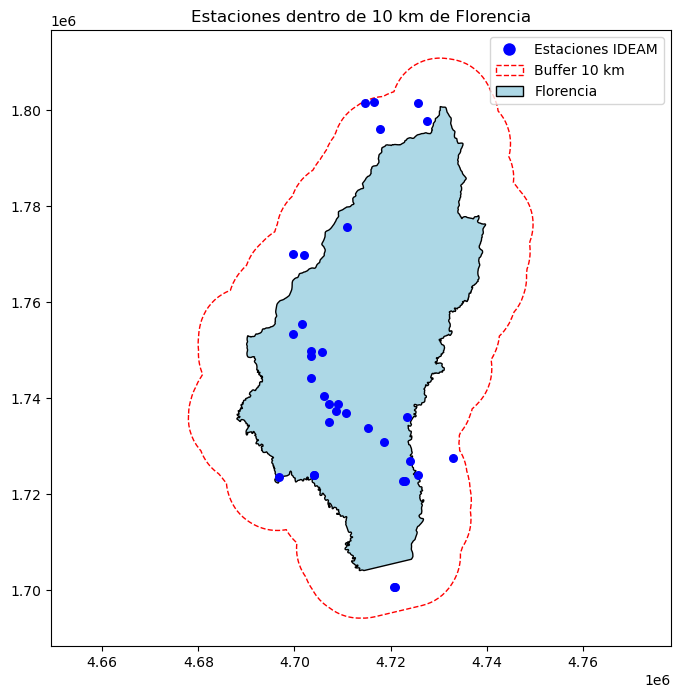

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
florencia_buffer.plot(ax=ax, edgecolor='red', linestyle='--', facecolor='none')
mun_sel.plot(ax=ax, color='lightblue', edgecolor='black')
estaciones_20km_florencia.plot(ax=ax, color='blue', markersize=30)

# Zoom
xmin, ymin, xmax, ymax = florencia_buffer.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estaciones IDEAM',
           markerfacecolor='blue', markersize=10),
    mpatches.Patch(edgecolor='red', facecolor='none', linestyle='--', label='Buffer 10 km'),
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label='Florencia')
]
ax.legend(handles=legend_elements)

plt.title("Estaciones dentro de 10 km de Florencia")
plt.axis('equal')
plt.show()

In [56]:
# Intersecar RUNAP con el municipio seleccionado, conservando todas las geometrías
runap_in_mun = gpd.overlay(gdf_runap, gdf_mun, how='intersection', keep_geom_type=False)
print(f"Áreas protegidas (RUNAP) dentro del municipio: {len(runap_in_mun)}")

# Filtrar solo polígonos y multipolígonos para evitar líneas o geometrías inválidas
runap_in_mun = runap_in_mun[runap_in_mun.geometry.type.isin(['Polygon', 'MultiPolygon'])].reset_index(drop=True)
print(f"RUNAP filtrado a geometrías válidas (Polygon/MultiPolygon): {len(runap_in_mun)}")

# Quitar del grid las celdas que intersectan áreas protegidas
grid_fina_no_protegida = gpd.overlay(grid_fina, runap_in_mun, how='difference', keep_geom_type=False)
print(f"Celdas válidas fuera de áreas protegidas: {len(grid_fina_no_protegida)}")

# Asegurarse de mantener solo celdas poligonales tras la operación difference
grid_fina_no_protegida = grid_fina_no_protegida[
    grid_fina_no_protegida.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)
print(f"Celdas finales con geometrías válidas: {len(grid_fina_no_protegida)}")

Áreas protegidas (RUNAP) dentro del municipio: 2905
RUNAP filtrado a geometrías válidas (Polygon/MultiPolygon): 2895
Celdas válidas fuera de áreas protegidas: 104480
Celdas finales con geometrías válidas: 104469


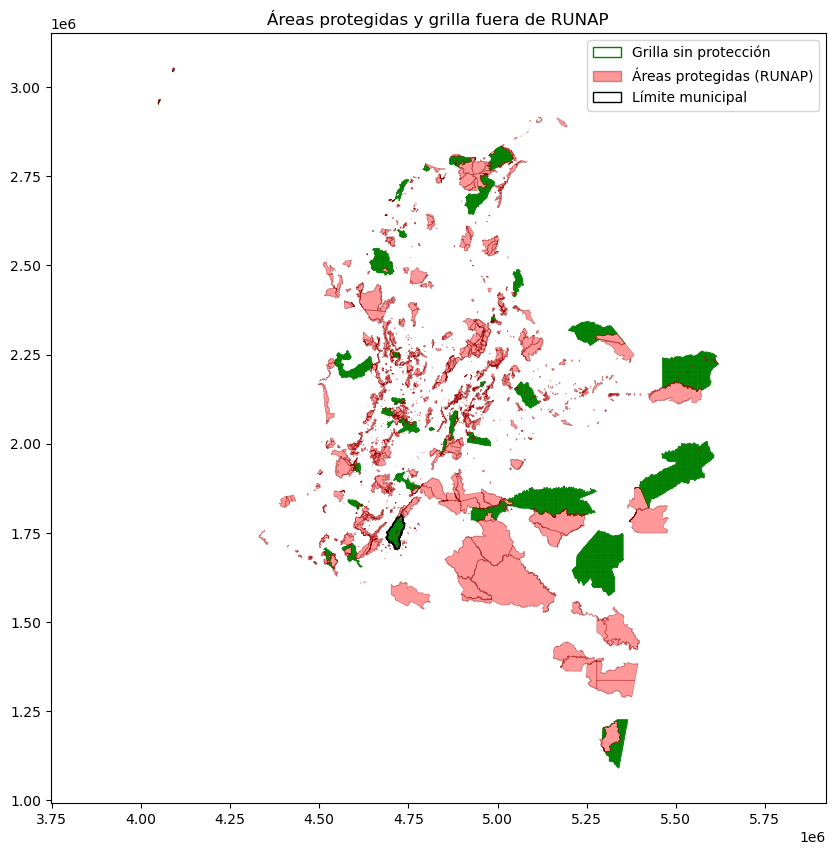

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Grilla sin áreas protegidas (final válida)
grid_fina_no_protegida.plot(ax=ax, color='white', edgecolor='green', linewidth=0.3, label='Grilla sin protección')

# 2. Áreas protegidas RUNAP
runap_in_mun.plot(ax=ax, color='red', alpha=0.4, edgecolor='darkred', linewidth=0.5, label='Áreas protegidas (RUNAP)')

# 3. Límite del municipio
mun_sel.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, label='Florencia')

# Zoom automático
xmin, ymin, xmax, ymax = mun_sel.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='green', label='Grilla sin protección'),
    mpatches.Patch(facecolor='red', edgecolor='darkred', label='Áreas protegidas (RUNAP)', alpha=0.4),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Límite municipal'),
]

ax.legend(handles=legend_elements, loc='upper right')
plt.title("Áreas protegidas y grilla fuera de RUNAP")
plt.axis('equal')
plt.show()


### 4.2 - Calcular criterios locales (distancia a vías, estaciones, densidad poblacional)

In [19]:
from shapely.strtree import STRtree

# 1. Lista de geometrías
vias_geoms = list(gdf_vias.geometry)
est_geoms = list(gdf_est.geometry)
print(f"Geometrías cargadas: {len(vias_geoms)} vías, {len(est_geoms)} estaciones")

# 2. Crear árbol espacial
vias_tree = STRtree(vias_geoms)
est_tree = STRtree(est_geoms)

# 3. Calcular centroides de las celdas
centroids = grid_fina.geometry.centroid
print(f"Centroides calculados para {len(centroids)} celdas.")

# 4. Función de distancia mínima desde un punto a geometrías en un árbol
def min_dist_to_tree(point, tree, geoms):
    idxs = tree.query(point)
    if len(idxs) == 0:
        return np.nan
    return min(point.distance(geoms[i]) for i in idxs)

# 5. Aplicar distancias usando los árboles espaciales
grid_fina['dist_vias'] = [min_dist_to_tree(pt, vias_tree, vias_geoms) for pt in centroids]
grid_fina['dist_est'] = [min_dist_to_tree(pt, est_tree, est_geoms) for pt in centroids]

# Vista previa
print(grid_fina[['dist_vias', 'dist_est']].head())

Geometrías cargadas: 108228 vías, 8973 estaciones
Centroides calculados para 113741 celdas.
    dist_vias  dist_est
0   67.856810       NaN
1  346.108741       NaN
2   54.701617       NaN
3  117.892322       NaN
4  128.283111       NaN


### 4.3 - Normalización y selección de mejor celda

In [20]:
grid_fina[['c1_vias', 'c2_estaciones', 'c3_poblacion']] = MinMaxScaler().fit_transform(
    pd.DataFrame({
        'c1_vias': -grid_fina['dist_vias'],
        'c2_estaciones': -grid_fina['dist_est'],
        'c3_poblacion': -grid_fina['pop_density']
    }))

grid_fina['SCORE_LOCAL'] = (
    0.4 * grid_fina['c1_vias'] +
    0.3 * grid_fina['c2_estaciones'] +
    0.3 * grid_fina['c3_poblacion'])

best_cell = grid_fina.sort_values('SCORE_LOCAL', ascending=False).head(1)

/opt/miniconda/lib/python3.11/site-packages/sklearn/utils/_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/opt/miniconda/lib/python3.11/site-packages/sklearn/utils/_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


## Visualización final

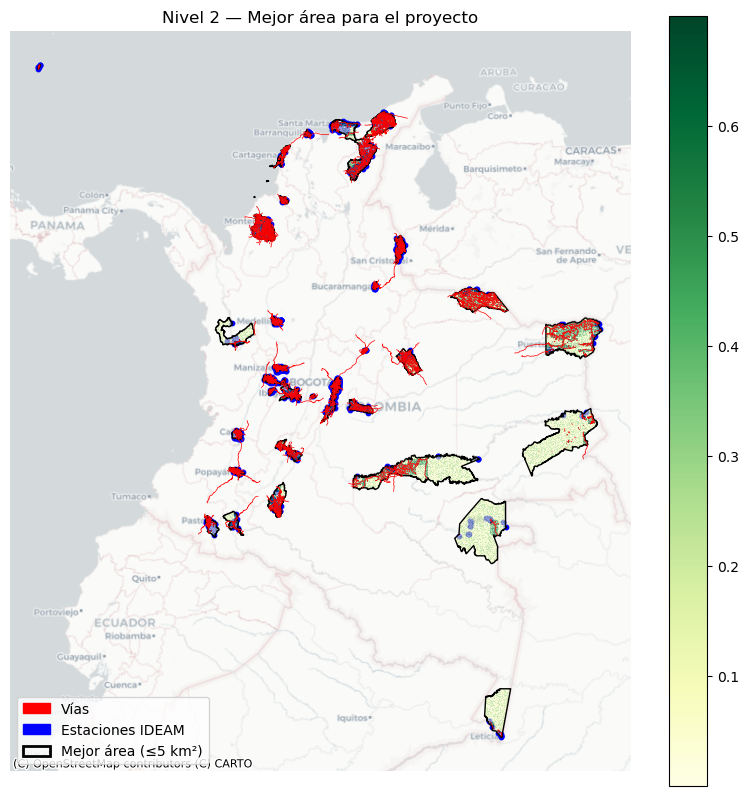

In [152]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo
mun_sel.boundary.plot(ax=ax, color='black', linewidth=1)
vias_mun.plot(ax=ax, color='red', linewidth=0.5)
est_mun.plot(ax=ax, color='blue', markersize=10)
grid_fina.plot(ax=ax, column='SCORE_LOCAL', cmap='YlGn', alpha=0.6, legend=True)
best_cell.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Basemap
ctx.add_basemap(ax, crs=mun_sel.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Título
plt.title("Nivel 2 — Mejor área para el proyecto")
plt.axis('off')

# Leyenda personalizada
custom_legend = [
    mpatches.Patch(color='red', label='Vías'),
    mpatches.Patch(color='blue', label='Estaciones IDEAM'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Mejor área (≤5 km²)', linewidth=2)
]
plt.legend(handles=custom_legend, loc='lower left')

plt.show()


NameError: name 'vias_mun' is not defined

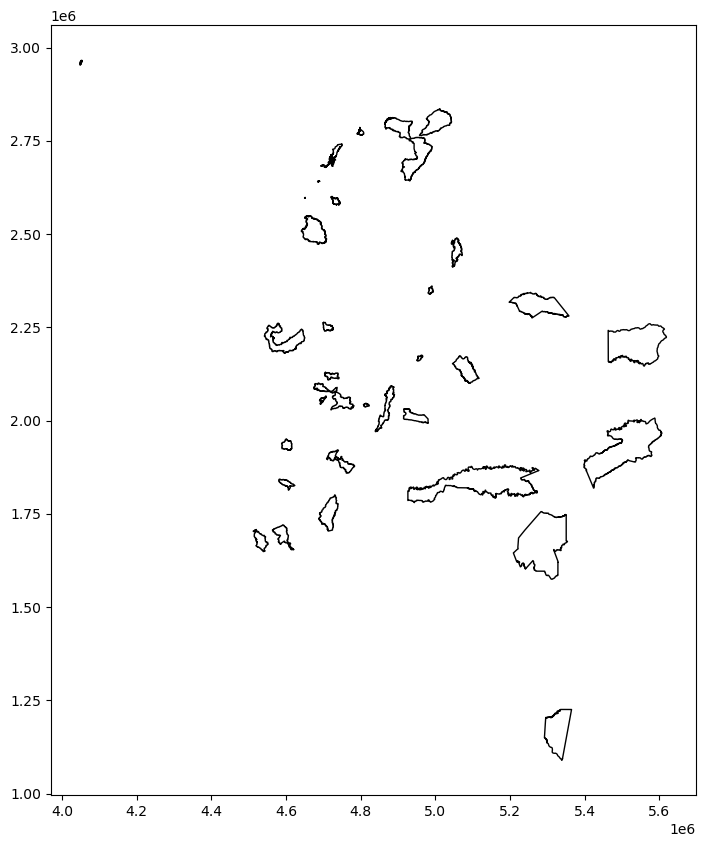

In [21]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo
mun_sel.boundary.plot(ax=ax, color='black', linewidth=1)
vias_mun.plot(ax=ax, color='red', linewidth=0.5)
est_mun.plot(ax=ax, color='blue', markersize=10)
grid_fina.plot(ax=ax, column='SCORE_LOCAL', cmap='YlGn', alpha=0.6, legend=True)
best_cell.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Basemap
ctx.add_basemap(ax, crs=mun_sel.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Título
plt.title("Nivel 2 — Mejor área para el proyecto")
plt.axis('off')

# Leyenda personalizada
custom_legend = [
    mpatches.Patch(color='red', label='Vías'),
    mpatches.Patch(color='blue', label='Estaciones IDEAM'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Mejor área (≤5 km²)', linewidth=2)
]
plt.legend(handles=custom_legend, loc='lower left')

plt.show()

In [153]:
# Filtrar municipios que tengan al menos algún valor en todos los criterios
mun_validos = mun_scores[
    (mun_scores['ideam_count'] > 0) &
    (mun_scores['length_m'] > 0) &
    (mun_scores['maiz_prod_ton'] > 0) &
    (mun_scores['population_part'] > 0)
]


In [154]:
# Ordenar por SCORE descendente
mejor_municipio = mun_validos.sort_values('SCORE', ascending=False).head(1)

# Mostrar el resultado
display(mejor_municipio[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])


,MPIO_CCDGO,MPIO_CNMBR,SCORE


In [155]:
condiciones = [
    mun_scores['ideam_count'] > 0,
    mun_scores['length_m'] > 0,
    mun_scores['maiz_prod_ton'] > 0,
    mun_scores['population_part'] > 0
]

# Sumar condiciones verdaderas por municipio
mun_scores['condiciones_validas'] = sum(condiciones)

# Filtrar municipios con al menos 3 condiciones cumplidas
mun_validos = mun_scores[mun_scores['condiciones_validas'] >= 3]


In [156]:
mejor_municipio = mun_validos.sort_values('SCORE', ascending=False).head(1)
display(mejor_municipio[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])


,MPIO_CCDGO,MPIO_CNMBR,SCORE
628,00001,SAN ANDRÉS,0.75


In [157]:
print("Con estaciones:", (mun_scores['ideam_count'] > 0).sum())
print("Con vías:", (mun_scores['length_m'] > 0).sum())
print("Con producción de maíz:", (mun_scores['maiz_prod_ton'] > 0).sum())
print("Con población estimada:", (mun_scores['population_part'] > 0).sum())


Con estaciones: 1101
Con vías: 1118
Con producción de maíz: 0
Con población estimada: 1122


In [158]:
# Extraer geometría y datos del municipio final
municipio_final = gdf_mun[gdf_mun["MPIO_CCDGO"] == mejor_municipio.iloc[0]["MPIO_CCDGO"]]
